# UCB1

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class Epsilon:
    """
    Agente que soluciona el problema del el Bandido Multibrazo
    (Multi-Armed Bandit) mediante el uso de una estrategia Epsilon
    Greedy
    
    Parámetros
    ----------
    bandits : array of Bandit
        Vector con los bandidos con los que se debe jugar
    epsilon : float
        Porcentaje de veces en las que el agente jugada de forma
        aleatoria
    decay : float
        Velocidad con la que decae la probabilidad de seleccionar una
        jugada al azar
    initial: array of float
        Valor inicial de la recompensa esperada para cada uno de
        bandidos
    Métodos
    -------
    run :
        Realiza una tirada en el bandido
    average_reward :
        Obtención de la recompensa promedio
    plot :
        Representación gráfica del histórico de jugadas
    reset :
        Reinicia el agente
    """
    
    def __init__(self, bandits, epsilon=0.05, decay=1, initial=None):
        self.bandits = bandits
        self.epsilon = epsilon
        self.decay = decay
        self.reset(initial)
        
        
    def run(self, episodes=1):
        for i in range(episodes):
            prob = np.random.random()
            
            # Selección entre la jugada aleatoria o avariciosa
            if prob < self._epsilon:
                bandit = np.random.choice(len(bandits))
            else:
                max_bandits = np.where(self._mean == np.max(self._mean))[0]
                bandit = np.random.choice(max_bandits)

            # Decaimiento del parámetro epsilon
            self._epsilon *= self.decay
            
            # Obtención de una nueva recompensa
            reward = bandits[bandit].pull()
            
            # Agregación de la recompensa al listado
            self._rewards.append(reward)
            
            # Actualización de la media
            self._plays[bandit] += 1
            self._mean[bandit] = (1 - 1.0/self._plays[bandit]) * self._mean[bandit] \
                                 + 1.0/self._plays[bandit] * reward
        
        return self.average_reward()
    
    
    def average_reward(self):
        return np.mean(self._rewards)
    
    
    def plot(self, log=False, reference=False, label=None):
        cumulative_average = np.cumsum(self._rewards) / (np.arange(len(self._rewards)) + 1)
        
        if label is None:
            plt.plot(range(len(self._rewards)), cumulative_average)
        else:
            plt.plot(range(len(self._rewards)), cumulative_average, label=label)
            
        if reference:
            for reward in [b.reward for b in self.bandits]:
                plt.plot([0, len(self._rewards)], [reward, reward],
                         label=f'reward={reward}')
                
        if log:
            plt.xscale('log')
    
    
    def reset(self, initial=None):
        self._rewards = []
        
        if initial is None:
            self._epsilon = self.epsilon
            self._plays = [0] * len(self.bandits)
            self._mean = [0] * len(self.bandits)
        else:
            self._epsilon = 0
            self._plays = [1] * len(self.bandits)
            self._mean = initial

In [5]:
class Bandit:
    """
    Implementación de un Bandido Multibrazo (Multi-Armed Bandit) basado
    en una distribución binomial

    Parámetros
    ----------
    number: integer
        Número de recompensas que puede devolver el agente
    probability : float
        Probabilidad de que el objeto devuelva una recompensa
    
    Métodos
    -------
    pull :
        Realiza una tirada en el bandido
        
    """
    def __init__(self, probability, number=1):
        self.number = number
        self.probability = probability
        self.reward = self.number * self.probability
        
        
    def pull(self):        
        return np.random.binomial(self.number, self.probability) 
        
    
    


In [7]:
class UCB(Epsilon):
    def __init__(self, bandits):
        self.bandits = bandits
        
        self.reset()
    def run(self, episodes=1):
        for i in range(episodes):
            # Selección del bandido
            bandit = self.select()
            
            # Obtención de una nueva recompensa
            reward = bandits[bandit].pull()
            
            # Agregación de la recompensa al listado
            self._rewards.append(reward)
            
            # Actualización de la media
            self._rewards2[bandit] += reward ** 2
            self._plays[bandit] += 1
            self._mean[bandit] = (1 - 1.0/self._plays[bandit]) * self._mean[bandit] \
                                 + 1.0/self._plays[bandit] * reward
        
        return self.average_reward()
    def select(self):
        num_bandits = len(self.bandits)
        total = len(self._rewards)
        
        if total == 0:
            bandit = np.random.choice(len(bandits))
        else:
            ucb = [0] * num_bandits
            
            for i in range(num_bandits):
                if self._plays[i] == 0:
                    ucb[i] = self._mean[i] + np.sqrt(2 * np.log(total))
                else:
                    ucb[i] = self._mean[i] + np.sqrt(2 * np.log(total) / self._plays[i])
        
            max_bandits = np.where(ucb == np.max(ucb))[0]
            bandit = np.random.choice(max_bandits)
            
        return bandit
    
    
    def reset(self, initial=None):
        self._rewards = []
        self._plays = [0] * len(self.bandits)
        self._mean = [0] * len(self.bandits)
        self._rewards2 = [0] * len(self.bandits)

# Thompson Sampling

In [2]:
from scipy.stats import beta

class ThompsonSampling(Epsilon):
    def __init__(self, bandits, N=1):
        self.bandits = bandits
        self.N = N
            
        self.reset()
        
    def run(self, episodes=1):
        for i in range(episodes):
            # Selección del bandido
            bandit = self.select()
            
            # Obtención de una nueva recompensa
            reward = bandits[bandit].pull()
            
            # Agregación de la recompensa al listado
            self._rewards.append(reward)
            
            # Actualización de la media
            self._plays[bandit] += 1
            self._mean[bandit] = (1 - 1.0/self._plays[bandit]) * self._mean[bandit] \
                                 + 1.0/self._plays[bandit] * reward
            
            # Guardado de valores intermedos
            self._alpha[bandit] += reward
            self._beta[bandit] += (self.N - reward)
            
            
    def select(self):
        num_bandits = len(self.bandits)
        bayes = [0] * num_bandits
        
        for i in range(num_bandits):
            bayes[i] = beta.rvs(self._alpha[i], self._beta[i])
            
        max_bandits = np.where(bayes == np.max(bayes))[0]
        bandit = np.random.choice(max_bandits)
        
        return bandit
    
    
    def reset(self, initial=None):
        self._rewards = []
        self._plays = [0] * len(self.bandits)
        self._mean = [0] * len(self.bandits)
        
        self._alpha = [1] * len(self.bandits)
        self._beta = [1] * len(self.bandits)

# BayesUCB

In [3]:
class BayesUCB(ThompsonSampling):
    def __init__(self, bandits, N=1, gamma=3):
        self.bandits = bandits
        self.N = N
        self.gamma = gamma
        
        self.reset()

    
    def select(self):
        num_bandits = len(self.bandits)
        bayes = [0] * num_bandits
        
        for i in range(num_bandits):
            bayes[i] = self._mean[i] + beta.std(self._alpha[i], self._beta[i]) * self.gamma
            
        max_bandits = np.where(bayes == np.max(bayes))[0]
        bandit = np.random.choice(max_bandits)
            
        return bandit

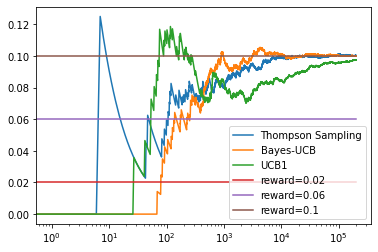

In [8]:
np.random.seed(0)

bandits = [Bandit(0.02), Bandit(0.06), Bandit(0.10)]

thompson = ThompsonSampling(bandits)
ucb_n = BayesUCB(bandits)
ucb_1 = UCB(bandits)

thompson.run(200000)
ucb_n.run(200000)
ucb_1.run(200000)

thompson.plot(True, label='Thompson Sampling')
ucb_n.plot(True, label='Bayes-UCB')
ucb_1.plot(True, True, label='UCB1')
plt.legend();

# Comparación de todos

# UCB2

In [9]:
import sys

class UCB2(Epsilon):
    def __init__(self, bandits, alpha=0.1):
        self.bandits = bandits
        self.alpha = alpha
        
        self.reset()
    
    def run(self, episodes=1):
        for i in range(episodes):
            # Selección del bandido
            bandit = self.select()
            
            # Obtención de una nueva recompensa
            reward = bandits[bandit].pull()
            
            # Agregación de la recompensa al listado
            self._rewards.append(reward)
            
            # Actualización de la media
            self._rewards2[bandit] += reward ** 2
            self._plays[bandit] += 1
            self._mean[bandit] = (1 - 1.0/self._plays[bandit]) * self._mean[bandit] \
                                 + 1.0/self._plays[bandit] * reward
    def select(self):
        num_bandits = len(self.bandits)
        total = len(self._rewards)
        
        if total == 0:
            bandit = np.random.choice(len(bandits))
        else:
            ucb = [0] * num_bandits
            
            for i in range(num_bandits):
                try:
                    tau = int(np.ceil((1 + self.alpha) ** self._plays[i]))
                    if np.log(np.e * total / tau) > 0:
                        bonus = np.sqrt((1. + self.alpha) * np.log(np.e * total / tau) / (2 * tau))
                    else:
                        bonus = 0
                except:
                    bonus = 0
                    
                if np.isnan(bonus):
                    ucb[i] = self._mean[i] 
                else:
                    ucb[i] = self._mean[i] + bonus
        
            max_bandits = np.where(ucb == np.max(ucb))[0]
            bandit = np.random.choice(max_bandits)
            
        return bandit
    
    
    def reset(self, initial=None):
        self._rewards = []
        self._plays = [0] * len(self.bandits)
        self._mean = [0] * len(self.bandits)
        self._rewards2 = [0] * len(self.bandits)

# UCB1-Tuned

In [10]:
class UCB1Tuned(Epsilon):
    def __init__(self, bandits):
        self.bandits = bandits
        
        self.reset()
    
    
    def run(self, episodes=1):
        for i in range(episodes):
            # Selección del bandido
            bandit = self.select()
            
            # Obtención de una nueva recompensa
            reward = bandits[bandit].pull()
            
            # Agregación de la recompensa al listado
            self._rewards.append(reward)
            
            # Actualización de la media
            self._plays[bandit] += 1
            self._mean[bandit] = (1 - 1.0/self._plays[bandit]) * self._mean[bandit] \
                                 + 1.0/self._plays[bandit] * reward
            
            # Actualización de la media de los cuadrados
            self._mean2[bandit] = (1 - 1.0/self._plays[bandit]) * self._mean2[bandit] \
                                 + 1.0/self._plays[bandit] * reward ** 2
        
        return self.average_reward()
    
    
    def select(self):
        num_bandits = len(self.bandits)
        total = len(self._rewards)
        
        if total == 0:
            bandit = np.random.choice(len(bandits))
        else:
            ucb = [0] * num_bandits
            
            for i in range(num_bandits):
                if self._plays[i] == 0:
                    v = self._mean2[i] - self._mean[i] ** 2 + np.sqrt(2 * np.log(total))
                else:
                    v = self._mean2[i] - self._mean[i] ** 2 + np.sqrt(2 * np.log(total) / self._plays[i])
        
                ucb[i] = self._mean[i] + np.sqrt(np.log(total) * np.min([1/4, v]))
            
            max_bandits = np.where(ucb == np.max(ucb))[0]
            bandit = np.random.choice(max_bandits)
            
        return bandit
    
    
    def reset(self, initial=None):
        self._rewards = []
        self._plays = [0] * len(self.bandits)
        self._mean = [0] * len(self.bandits)
        self._mean2 = [0] * len(self.bandits)

In [12]:
np.random.seed(0)

bandits = [Bandit(0.02), Bandit(0.06), Bandit(0.10)]

ucb_tuned = UCB1Tuned(bandits)
ucb_1 = UCB(bandits)
ucb_a = UCB2(bandits, 0.5)
ucb_b = UCB2(bandits, 0.3)
ucb_c = UCB2(bandits, 0.1)

ucb_a.run(200000)
ucb_b.run(200000)
ucb_c.run(200000)
ucb_tuned.run(200000)
ucb_1.run(200000)



0.097

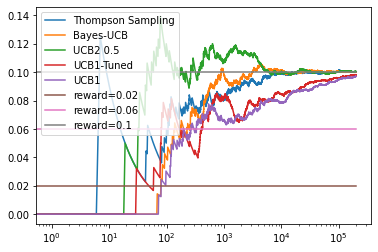

In [13]:
thompson.plot(True, label='Thompson Sampling')
ucb_n.plot(True, label='Bayes-UCB')
ucb_a.plot(True, label='UCB2 0.5')
ucb_tuned.plot(True, label='UCB1-Tuned')
ucb_1.plot(True, True, label='UCB1')
plt.legend()
plt.legend()

In [15]:
print('UCB1 jugadas: ',ucb_1._plays)
print('UCB1-Tuned jugadas: ',ucb_tuned._plays)
print('UCB2 alpha=0.5 jugadas: ',ucb_a._plays)
print('Bayes-UCB: ',ucb_n._plays)
print('Thompson Sampling: ',thompson._plays)

UCB1 jugadas:  [3098, 8545, 188357]
UCB1-Tuned jugadas:  [2676, 8638, 188686]
UCB2 alpha=0.5 jugadas:  [16, 24, 199960]
Bayes-UCB:  [68, 525, 199407]
Thompson Sampling:  [117, 289, 199594]
